**Práctica 2**  
**Variables instrumentales**

Hay muchos estudios en economía laboral que tratan el tema de la estimación de las funciones de ingresos del capital humano y que establecen cómo los ingresos salariales están determinados por la educación y la experiencia laboral. Un ejemplo destacado es Card (1993), que investiga el rendimiento económico de la educación y utiliza la proximidad a la universidad como variable instrumental.
Esta práctica utiliza el conjunto de datos CollegeDistance, que es similar a los datos utilizados por Card (1993). Proviene de una encuesta de graduados con variables codificadas como salario, educación, matrícula promedio y una serie de medidas socioeconómicas. El conjunto de datos también incluye la distancia desde una universidad mientras los participantes de la encuesta estaban en la escuela. CollegeDistance viene con el paquete AER.
La regresión del salario en la educación y las variables de control para estimar la función de ingresos del capital humano es problemática porque la educación no se asigna al azar entre los encuestados: las personas toman sus propias decisiones de educación y, por lo tanto, las diferencias medidas en los ingresos entre las personas con diferentes niveles de educación dependen de cómo estas elecciones son hechos.
En la literatura, esto se conoce como un problema de selección e implica que la educación es endógena, por lo que la estimación de MCO estará sesgada y no podemos hacer una inferencia válida con respecto al coeficiente verdadero.
Instrucciones
1. Adjunte el paquete AER y cargue los datos de CollegeDistance.
2. Obtenga una descripción general del conjunto de datos. Específicamente, tome en cuenta que la variable distancia (la distancia a la escuela más cercana en 10 millas) servirá como instrumento en las estimaciones. Utilice un histograma para visualizar la distribución de la distancia.
3. Estime dos regresiones cuyos resultados no son confiables debido al problema de selección. Guarde estos resultados para compararlos posteriormente con los obtenidos mediante el enfoque de variables instrumentales aplicado por Card (1993). Estime por ejemplo el modelo: $$ log(wage) = \beta_{0} +  \beta_{1}log(education) + u $$ y luego incluya otros regresores como: desigual, hispano, afam, femenino y urbano. Interprete sus resultados.  
4. ¿Por qué se puede utilizar la distancia a la escuela como instrumento? Justifique el motivo por el cual esta variable podría ser utilizada como un instrumento.
5. Calcule las correlaciones de la distancia del instrumento con la educación regresora endógena y la variable dependiente salario. ¿Qué parte de la variación en la educación se explica por la regresión de la primera etapa que utiliza la distancia como regresor?
6. Repita las estimaciones anteriores utilizando IV, es decir, utilice la distancia como un instrumento para la educación en ambas regresiones mediante la función ivreg(). Guarde sus resultados y obtenga los errores estándar robustos para ambos modelos.
7. Verifique que sus resultados coinciden con los obtenidos cuando utiliza el procedimiento de estimación mediante las dos regresiones de MC2E para ambos modelos.
8. Interprete sus resultados en el contexto del problema, esto es, cuáles son los rendimientos de la educación estimados y el efecto del sesgo de selección en el modelo.
9. Realice las pruebas de verificación de variables instrumentales (endogeneidad de la regresora, relevancia del instrumento y exogeneidad del instrumento).
10. Pruebe si su instrumento es débil. Tome en cuenta que las familias con un fuerte interés por la educación pueden mudarse a vivir cerca de las universidades. Además, los vecindarios cercanos a las universidades pueden tener mercados laborales más fuertes reflejados en ingresos más altos. Tales características pueden invalidar el instrumento, ya que introducen variables no observadas que influyen en los ingresos, pero que no pueden ser capturadas por años de escolaridad, la medida de educación.


**Setup**

In [1]:
import pandas as pd
import numpy as np

# modelling
# import statsmodels.regression.linear_model as sm
from linearmodels.iv import IV2SLS

# plot
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1.Datos
Adjunte el paquete AER y cargue los datos de CollegeDistance.

Se hacen transformaciones en variables que serán útiles para la estimación de los efectos causales.

In [2]:
collegedistance_object = sm.datasets.get_rdataset(
    dataname="CollegeDistance",
    package="AER",
    cache=True
)
college_distance = collegedistance_object.data
college_distance['log_wage'] = np.log(college_distance['wage'])
college_distance['log_education'] = np.log(college_distance['education'])
college_distance['female'] = np.where(college_distance['gender']=='female', 1,0)
college_distance['hispanic'] = np.where(college_distance['ethnicity']=='hispanic', 1,0)
college_distance.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region,log_wage,log_education,female,hispanic
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other,2.090629,2.484907,0,0
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other,2.090629,2.484907,1,0
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other,2.090629,2.484907,0,0
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other,2.090629,2.484907,0,0
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other,2.090629,2.564949,1,0


# 2.EDA
Obtenga una descripción general del conjunto de datos. Específicamente, tome en cuenta que la variable distancia (la distancia a la escuela más cercana en 10 millas) servirá como instrumento en las estimaciones. Utilice un histograma para visualizar la distribución de la distancia.

La base de datos original contiene  14 variables y 4,739 observaciones, de las cuales 8 son categóricas y 6 discretas y continuas. Al agregar las transformaciones, señaladas en el apartado anterior, las variables aumentan a 18 (8 categóricas, 8 numéricas y 2 dicotómicas).

In [3]:
college_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4739 entries, 1 to 9431
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         4739 non-null   object 
 1   ethnicity      4739 non-null   object 
 2   score          4739 non-null   float64
 3   fcollege       4739 non-null   object 
 4   mcollege       4739 non-null   object 
 5   home           4739 non-null   object 
 6   urban          4739 non-null   object 
 7   unemp          4739 non-null   float64
 8   wage           4739 non-null   float64
 9   distance       4739 non-null   float64
 10  tuition        4739 non-null   float64
 11  education      4739 non-null   int64  
 12  income         4739 non-null   object 
 13  region         4739 non-null   object 
 14  log_wage       4739 non-null   float64
 15  log_education  4739 non-null   float64
 16  female         4739 non-null   int64  
 17  hispanic       4739 non-null   int64  
dtypes: float

El resumen estadístico de las variables de interés muestra que:
- El salario va de  a 6.59 mil usd a 12.96 mil usd, con una media de 9.5 mil usd. 
- La educación tiene valores de 12 años de escolaridad como mínimo y 18 como máximo, con una media de 13.8 años. 
- La distancia mínima de un centro universitario es de menos 1 milla y la máxima es de 200 millas, con un valor promedio de 18 millas. 

Los estadísticos descriptivos para el resto de las variables numéricas se muestran en la siguiente tabla.

In [4]:
college_distance.describe(include='number')

,score,unemp,wage,distance,tuition,education,log_wage,log_education,female,hispanic
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,50.889029,7.597215,9.500506,1.802870,0.814608,13.807765,2.241172,2.617042,0.548639,0.190547
std,8.701910,2.763581,1.343067,2.297128,0.339504,1.789107,0.143571,0.127210,0.497681,0.392774
min,28.950001,1.400000,6.590000,0.000000,0.257510,12.000000,1.885553,2.484907,0.000000,0.000000
25%,43.924999,5.900000,8.850000,0.400000,0.484990,12.000000,2.180418,2.484907,0.000000,0.000000
50%,51.189999,7.100000,9.680000,1.000000,0.824480,13.000000,2.270062,2.564949,1.000000,0.000000
75%,57.769999,8.900000,10.150000,2.500000,1.127020,16.000000,2.317474,2.772589,1.000000,0.000000
max,72.809998,24.900000,12.960000,20.000000,1.404160,18.000000,2.561868,2.890372,1.000000,1.000000


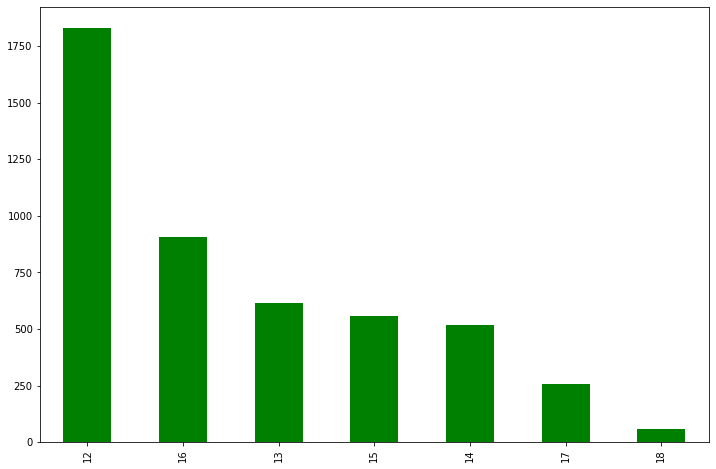

In [5]:
college_distance.education.value_counts().plot(kind='bar', color='green', figsize=(12,8));

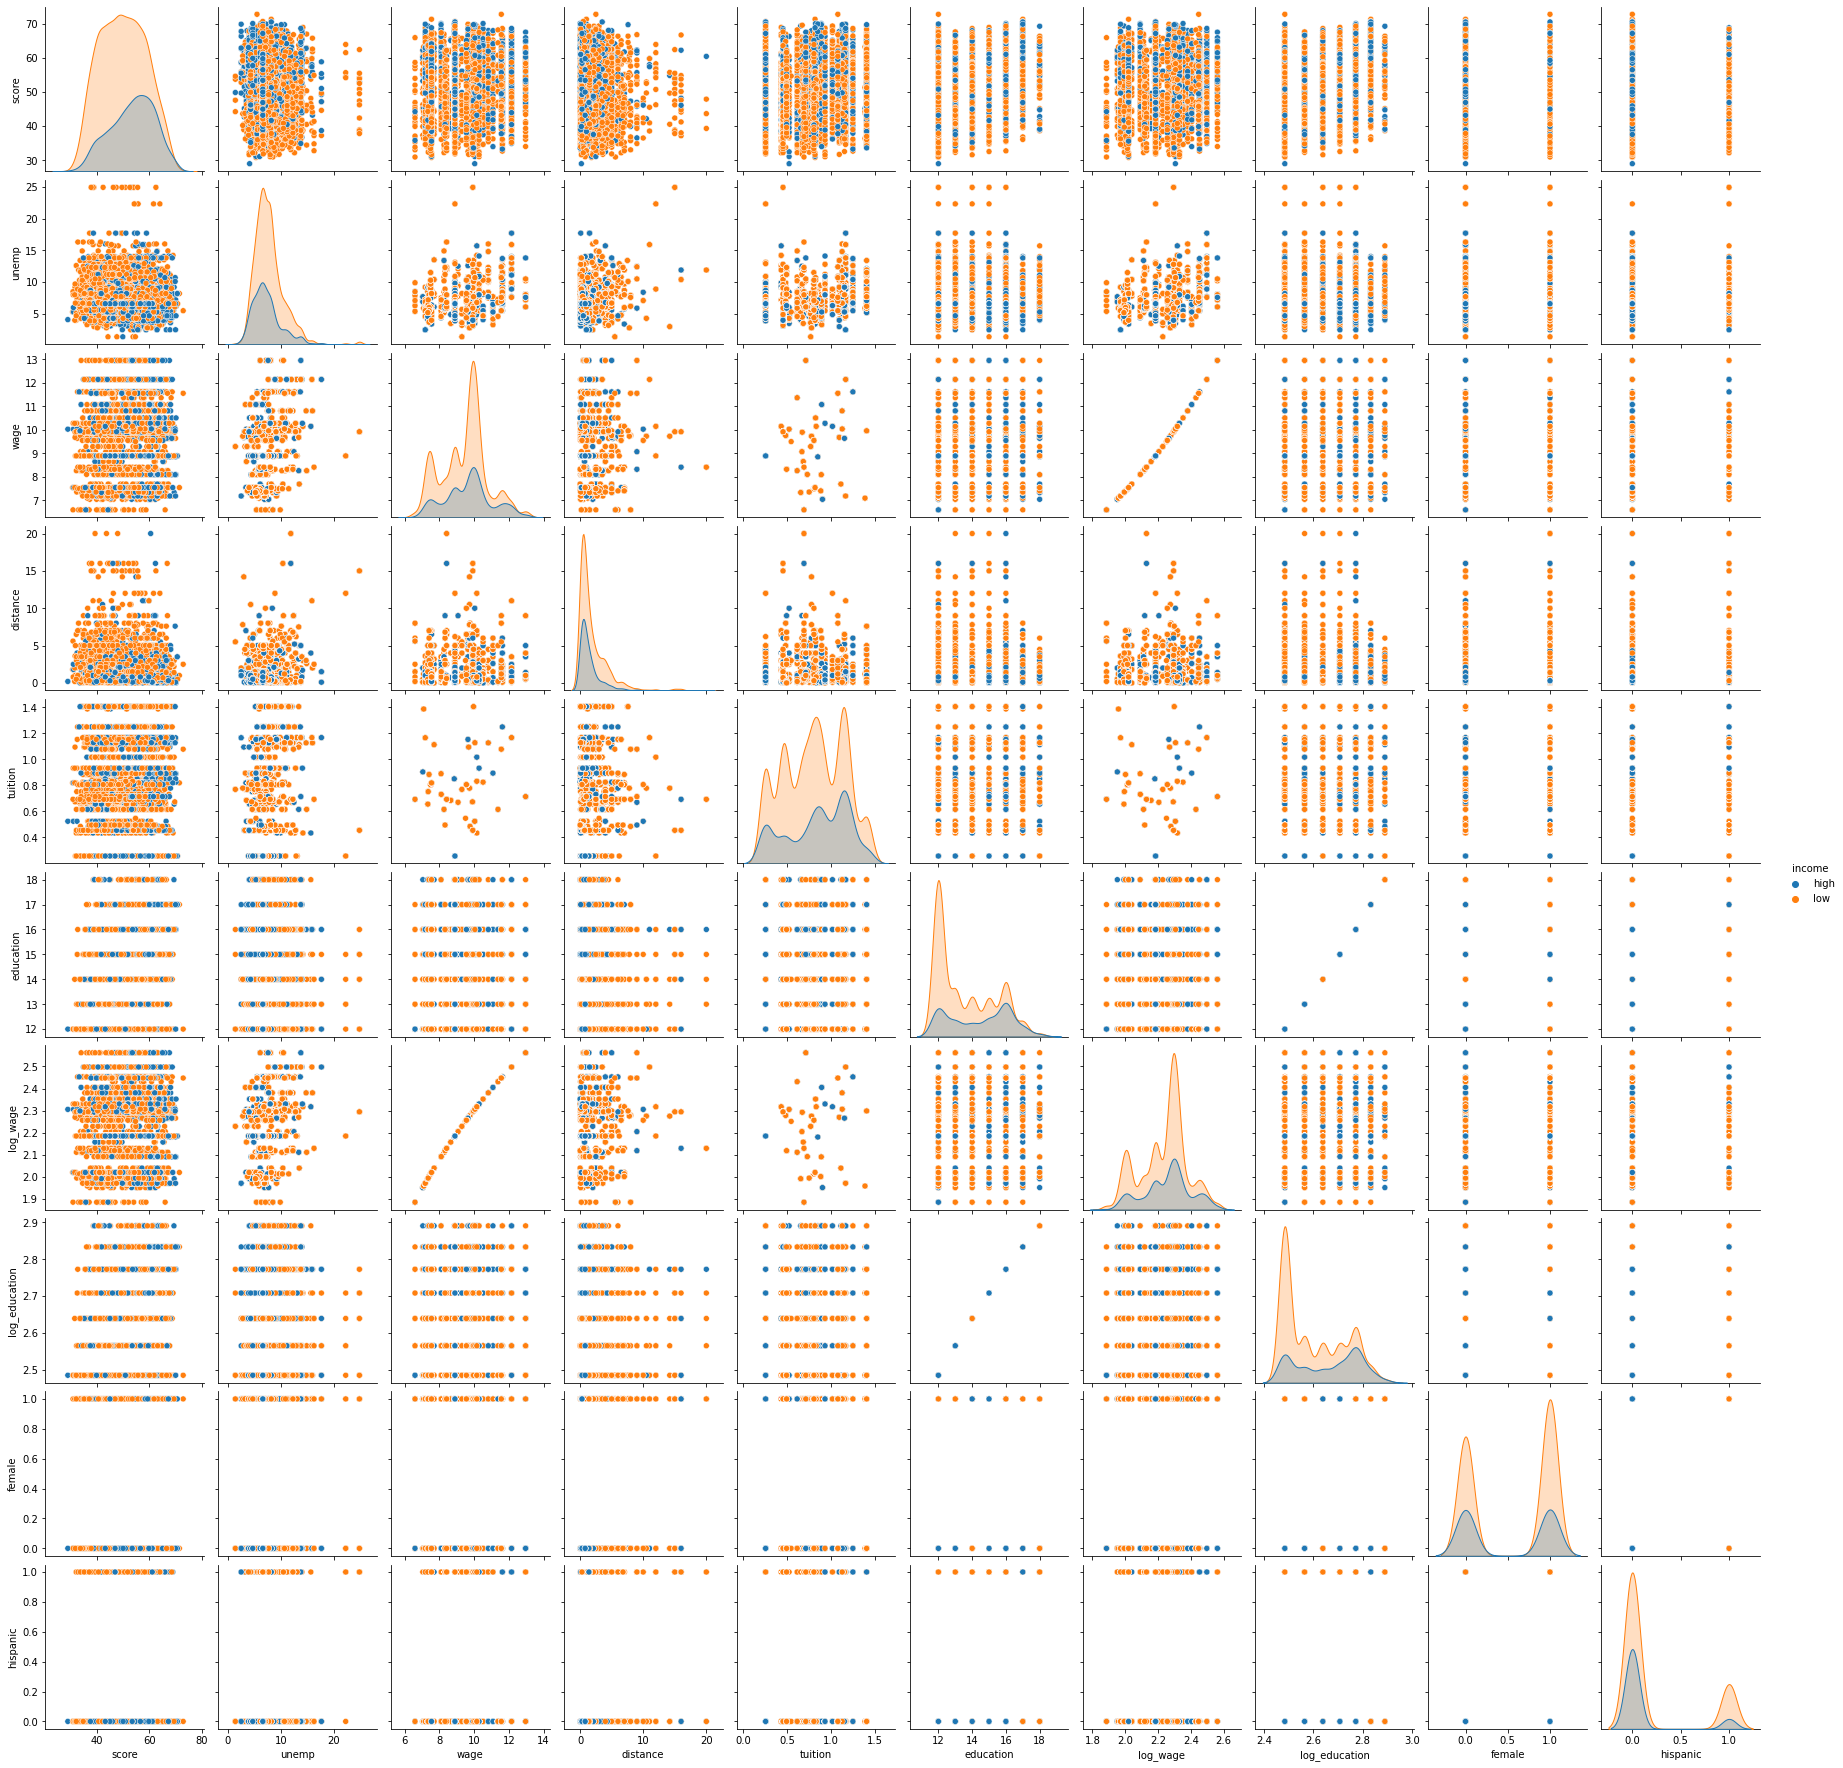

In [6]:
sns.pairplot(
    college_distance, 
    hue="income",
);

Respecto a las variables categóricas, los estadísticos descriptivos se muestran a continuación:

In [7]:
college_distance.describe(exclude='number')

,gender,ethnicity,fcollege,mcollege,home,urban,income,region
count,4739,4739,4739,4739,4739,4739,4739,4739
unique,2,3,2,2,2,2,2,2
top,female,other,no,no,yes,no,low,other
freq,2600,3050,3753,4088,3887,3635,3374,3796


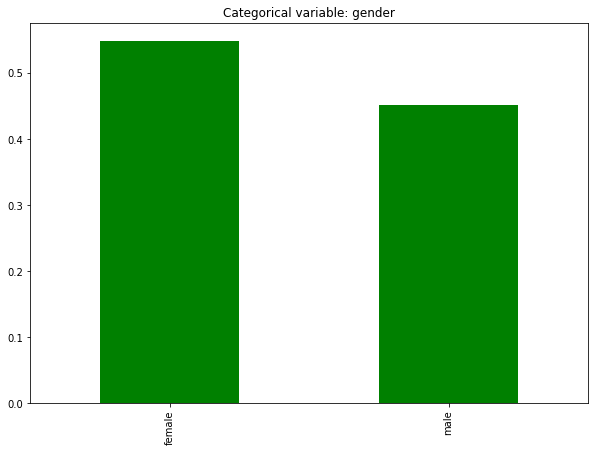

--------------------------------------------------


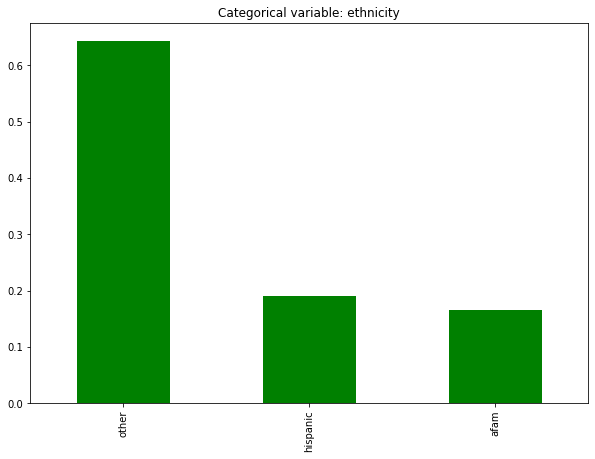

--------------------------------------------------


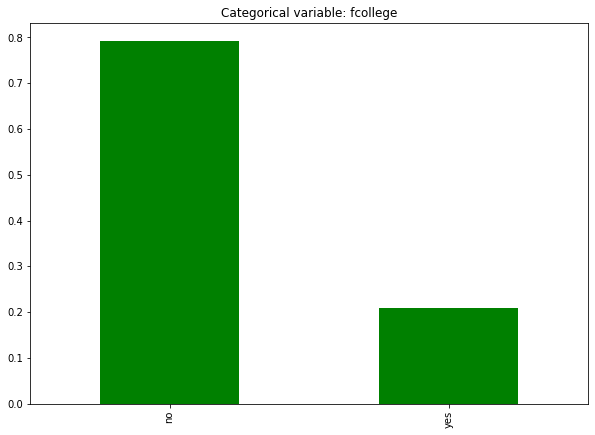

--------------------------------------------------


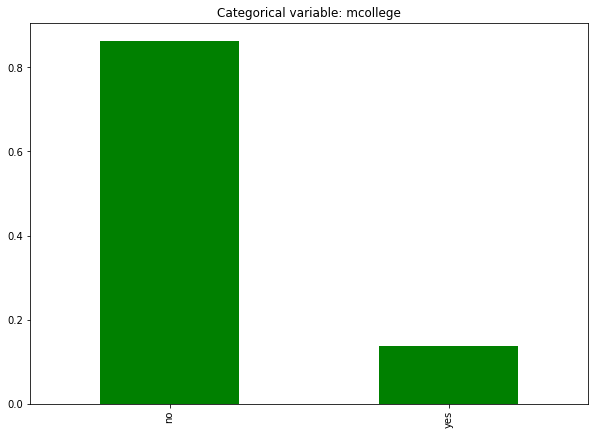

--------------------------------------------------


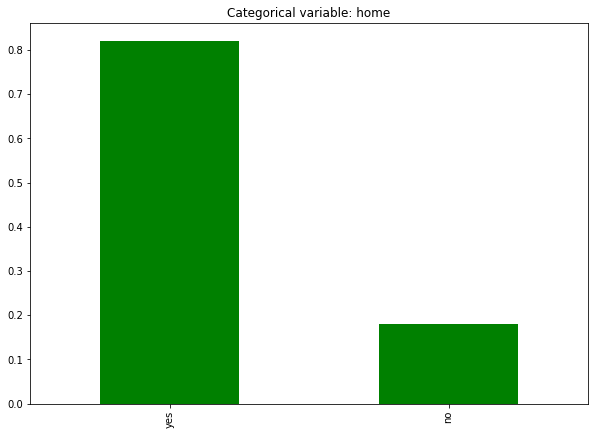

--------------------------------------------------


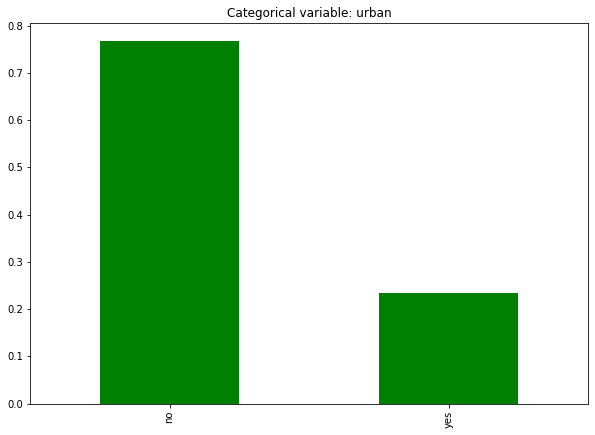

--------------------------------------------------


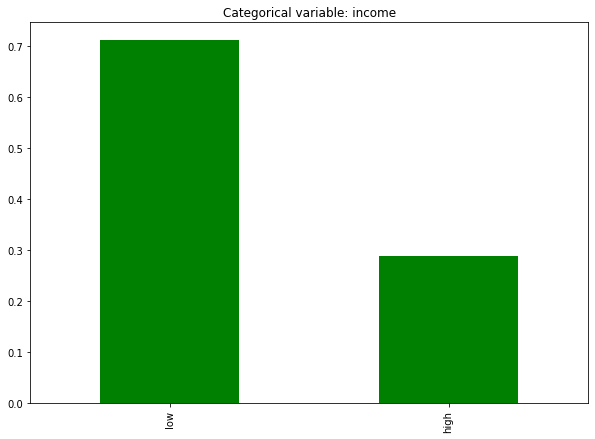

--------------------------------------------------


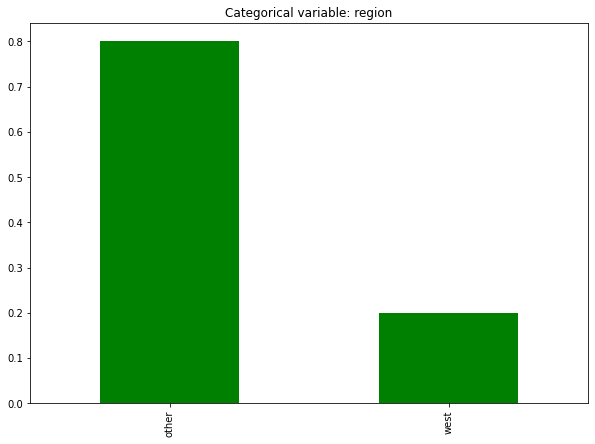

--------------------------------------------------


In [8]:
BOLD = '\033[1m'
END = '\033[0m'

for cat_var in college_distance.select_dtypes(exclude="number"):
#    print(f"Categorical variable: {BOLD}{cat_var}{END}")
    college_distance[cat_var].value_counts(dropna=False, normalize=True).plot(kind='bar',figsize=(10,7), color='green')
    plt.title(f"Categorical variable: {cat_var}")
#    plt.title(f"Categorical variable: {BOLD}{cat_var}{END}")
    plt.show();
    print(50*"-")

## Histograma de la distancia

La variable de distancia presenta una distribución cargada a la izquierda con una mediana de 10 millas. Un apunte más de la gráfica es la presencia de valores atípicos, posteriores al valor de XX, donde se encuentra el  95% de los datos.

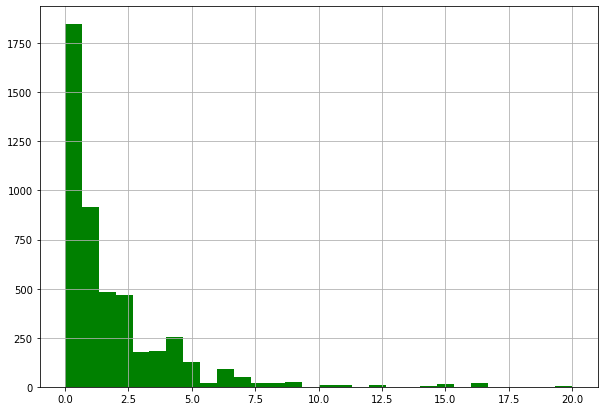

In [9]:
college_distance.distance.hist(bins=30, color='green',figsize=(10,7), );

# 3. Estimación de dos regresiones "no confiables"
Estime dos regresiones cuyos resultados no son confiables debido al problema de selección. Guarde estos resultados para compararlos posteriormente con los obtenidos mediante el enfoque de variables instrumentales aplicado por Card (1993). Estime por ejemplo el modelo: $$ log(wage) = \beta_{0} +  \beta_{1}log(education) + u $$ y luego incluya otros regresores como: desigual, hispano, afam, femenino y urbano. Interprete sus resultados. 

En la regresión (1) el parámetro que antecede la educación, B1, muestra la relación causal entre educación e ingreso, sin embargo esta relación es equivoca porque los factores que determinan el ingreso también podrían determinar la educación adquirida por los hombres jóvenes representados en esta base de datos.
Al incluir otros regresores observamos que el B1 cambia de magnitud, lo que muestra su sensibilidad ante cambios en la especificación y abona a la idea de la endogeneidad entre educación e ingreso, descrita previamente. 

In [20]:
#OLS
ols_reg = smf.ols(
    "log_wage~ log_education", 
    data = college_distance
).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.071
Date:                Sun, 20 Nov 2022   Prob (F-statistic):             0.0798
Time:                        17:15:28   Log-Likelihood:                 2475.7
No. Observations:                4739   AIC:                            -4947.
Df Residuals:                    4737   BIC:                            -4935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1660      0.043     50.429      0.000       2.082       2.250
log_education     0.0287      0.016      1.753      0.080      -0.003       0.061
==============================================================================
Omnibus:                       98.888   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.892
Skew:                          -0.252   Prob(JB):                     1.65e-18
Kurtosis:                       2.598   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#OLS
ols_reg = smf.ols(
    "log_wage~ log_education+female", 
    data = college_distance
).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.380
Date:                Sun, 20 Nov 2022   Prob (F-statistic):             0.0341
Time:                        17:15:28   Log-Likelihood:                 2477.6
No. Observations:                4739   AIC:                            -4949.
Df Residuals:                    4736   BIC:                            -4930.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1712      0.043     50.464      0.000       2.087       2.256
log_education     0.0284      0.016      1.735      0.083      -0.004       0.061
female           -0.0080      0.004     -1.920      0.055      -0.016       0.000
==============================================================================
Omnibus:                       98.142   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.245
Skew:                          -0.250   Prob(JB):                     2.28e-18
Kurtosis:                       2.599   Cond. No.                         63.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#OLS
ols_reg = smf.ols(
    "log_wage~ log_education+female+hispanic", 
    data = college_distance
).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     13.99
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           4.43e-09
Time:                        17:15:28   Log-Likelihood:                 2495.1
No. Observations:                4739   AIC:                            -4982.
Df Residuals:                    4735   BIC:                            -4956.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1883      0.043     50.931      0.000       2.104       2.273
log_education     0.0243      0.016      1.484      0.138      -0.008       0.056
female           -0.0085      0.004     -2.041      0.041      -0.017      -0.000
hispanic         -0.0314      0.005     -5.930      0.000      -0.042      -0.021
==============================================================================
Omnibus:                      107.314   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.107
Skew:                          -0.300   Prob(JB):                     8.19e-22
Kurtosis:                       2.636   Cond. No.                         63.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4.¿Por qué se puede utilizar la distancia a la escuela como instrumento? 
¿Por qué se puede utilizar la distancia a la escuela como instrumento? Justifique el motivo por el cual esta variable podría ser utilizada como un instrumento.

Después de la endogeneidad observada en las ecuaciones previas, la utilización de variables instrumentales es una medida que nos permitirá conocer los rendimientos de la educación en el ingreso a través de una estimación consistente. Para ello instrumentamos la variable educación a través de la distancia de la escuela. 
La distancia a la escuela podría ser considerada como instrumento porque reúne dos características: 
- No esta correlacionada con el termino de error de la ecuación (1), Cov (distancia,u)=0, 
- Esta correlacionada con la educación de los hombres jóvenes, Cov (distancia, educación)!=0. 

De acuerdo con Card (1993) las diferencias geográficas en la accesibilidad al colegio son una variable que representa la exogeneidad en la relación de educación e ingreso, porque no esta correlacionada con el ingreso y si esta correlacionada con la raza y la educación de los padres. 

# 5. Correlaciones de la distancia 
Calcule las correlaciones de la distancia del instrumento con la educación regresora endógena y la variable dependiente salario. ¿Qué parte de la variación en la educación se explica por la regresión de la primera etapa que utiliza la distancia como regresor?

A través del R2 observamos que la distancia explica la educación en XX%; mientras que la distancia no presenta una correlación significativa con el salario.

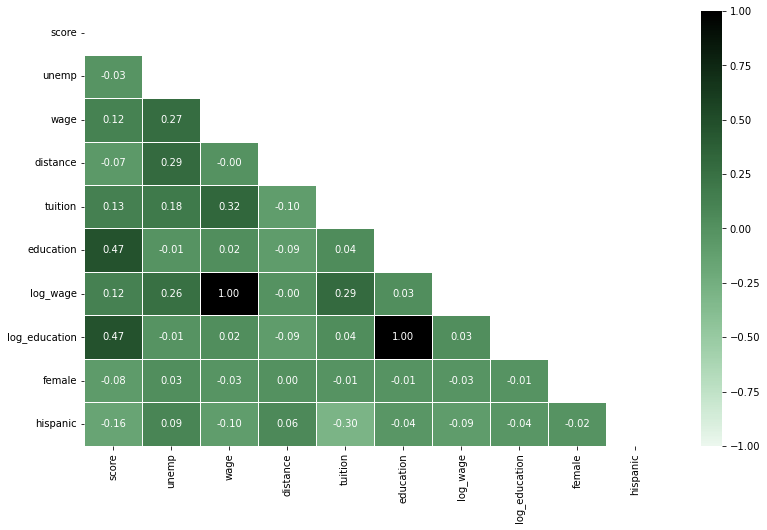

In [23]:
df_cor = college_distance.select_dtypes(include='number').corr()

fig, ax = plt.subplots(figsize=(13,8))         # Sample figsize in inches
mask = np.triu(df_cor)
sns.heatmap(
    df_cor, 
    annot=True, 
    linewidths=.5, 
    ax=ax, 
    cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True),
    mask=mask,
    vmin=-1,
    vmax=1,
    fmt=".2f"
)
plt.show();

# 6. Regresión IV
Repita las estimaciones anteriores utilizando IV, es decir, utilice la distancia como un instrumento para la educación en ambas regresiones mediante la función ivreg(). Guarde sus resultados y obtenga los errores estándar robustos para ambos modelos.

Al utilizar el instrumento encontramos una mejor estimación del efecto de la educación sobre el salario, sin tener la endogeneidad que representaba incluir la variable educación directamente. En esta ecuación el B equivale a XXX. 

In [25]:
mlr2 = IV2SLS(
    dependent=college_distance["log_wage"],
    endog=college_distance["log_education"],
    exog=college_distance["female"],
    instruments=college_distance["distance"]
).fit(
     cov_type="homoskedastic", debiased=True
)

mlr2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               log_wage   R-squared:                      0.9936
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9936
No. Observations:                4739   F-statistic:                 2.369e+05
Date:                Sun, Nov 20 2022   P-value (F-stat)                0.0000
Time:                        17:15:38   Distribution:                F(2,4737)
Cov. Estimator:         homoskedastic                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
female           -0.0347     0.0092    -3.7843     0.0002     -0.0527     -0.0167
log_education     0.8686     0.0032     268.11     0.0000      0.8623      0.8750
=================================================================================

Endogenous: log_education
Instruments: distance
Unadjusted Covariance (Homoskedastic)
Debiased: True
IVResults, id: 0x7f8289c6bdf0

In [26]:
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 28.9046
P-value: 0.0000
Distributed: F(1,4736)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 28.9046
P-value: 0.0000
Distributed: chi2(1)


In [27]:
mlr2 = IV2SLS(
    dependent=college_distance["log_wage"],
    endog=college_distance["log_education"],
    exog=college_distance[["female", "hispanic"]],
    instruments=college_distance["distance"]
).fit(
     cov_type="homoskedastic", debiased=True
)

mlr2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               log_wage   R-squared:                      0.9935
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9935
No. Observations:                4739   F-statistic:                 1.628e+05
Date:                Sun, Nov 20 2022   P-value (F-stat)                0.0000
Time:                        17:15:40   Distribution:                F(3,4736)
Cov. Estimator:         homoskedastic                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
female           -0.0379     0.0095    -3.9852     0.0001     -0.0565     -0.0192
hispanic         -0.0377     0.0081    -4.6842     0.0000     -0.0535     -0.0219
log_education     0.8725     0.0037     236.22     0.0000      0.8652      0.8797
=================================================================================

Endogenous: log_education
Instruments: distance
Unadjusted Covariance (Homoskedastic)
Debiased: True
IVResults, id: 0x7f8289d5b880

In [28]:
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 30.4305
P-value: 0.0000
Distributed: F(1,4735)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 30.4305
P-value: 0.0000
Distributed: chi2(1)


# 7. MC2E
Verifique que sus resultados coinciden con los obtenidos cuando utiliza el procedimiento de estimación mediante las dos regresiones de MC2E para ambos modelos.

# 8. Rendimientos de la educación
Interprete sus resultados en el contexto del problema, esto es, cuáles son los rendimientos de la educación estimados y el efecto del sesgo de selección en el modelo.

Los rendimientos de la educación sobre el salario al instrumentar la educación son equivalentes a X puntos porcentuales. Es decir, en promedio, un incremento en un año en la educación representa un incremento en X% del salario de los hombres jóvenes. Si hubiéramos considerado el B1 de la ecuación (1), la estimación habría sido X%, X puntos porcentuales más (menos) debido al sesgo de selección en ese modelo. Sesgo de selección, entre otros aspectos, por la sobrerrepresentación de un grupo de población en la muestra analizada y por la endogeneidad.

# 9. Pruebas de verificación
Realice las pruebas de verificación de variables instrumentales (endogeneidad de la regresora, relevancia del instrumento y exogeneidad del instrumento).

La prueba para verificar la debilidad de un instrumento es la prueba F, si se tiene más de un instrumento. En ese caso de debilidad de los instrumentos el valor F sería menor a 10. Con un solo instrumento, la regresión de la variable distancia con la educación es suficiente para verificar la Ho de que el parámetro que mide esta relación es significativo.

# 10. Debilidad del instrumento
Pruebe si su instrumento es débil. Tome en cuenta que las familias con un fuerte interés por la educación pueden mudarse a vivir cerca de las universidades. Además, los vecindarios cercanos a las universidades pueden tener mercados laborales más fuertes reflejados en ingresos más altos. Tales características pueden invalidar el instrumento, ya que introducen variables no observadas que influyen en los ingresos, pero que no pueden ser capturadas por años de escolaridad, la medida de educación.